Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [2]:
# Importing necessary libraries and modules for the project, including TensorFlow for deep learning tasks, matplotlib for visualization, numpy and pandas for data manipulation, PIL for image processing, and TensorFlow.keras for building neural network models.
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [3]:
# Mounting Google Drive to access files in Google Colab environment.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Unzipping the "CNN_assignment.zip".
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the paths for the training and testing datasets.
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [6]:
# Counting the number of images in the training and testing datasets.
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Loading images from disk using the image_dataset_from_directory utility provided by keras.preprocessing.

### Creating a dataset
Defining parameters for the loader.


In [7]:
# Setting parameters for the data loader: batch size, image height, and image width.
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training and 20% for validation

In [8]:
# Creating a training dataset using `image_dataset_from_directory` with a validation split of 20%, setting a random seed, and specifying the image size and batch size.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [42]:
# Creating a validation dataset using the `image_dataset_from_directory` function, which selects 20% of the images for validation, sets a random seed, and specifies the image size and batch size.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [10]:
# Getting the class names from the training dataset using the `class_names` attribute.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

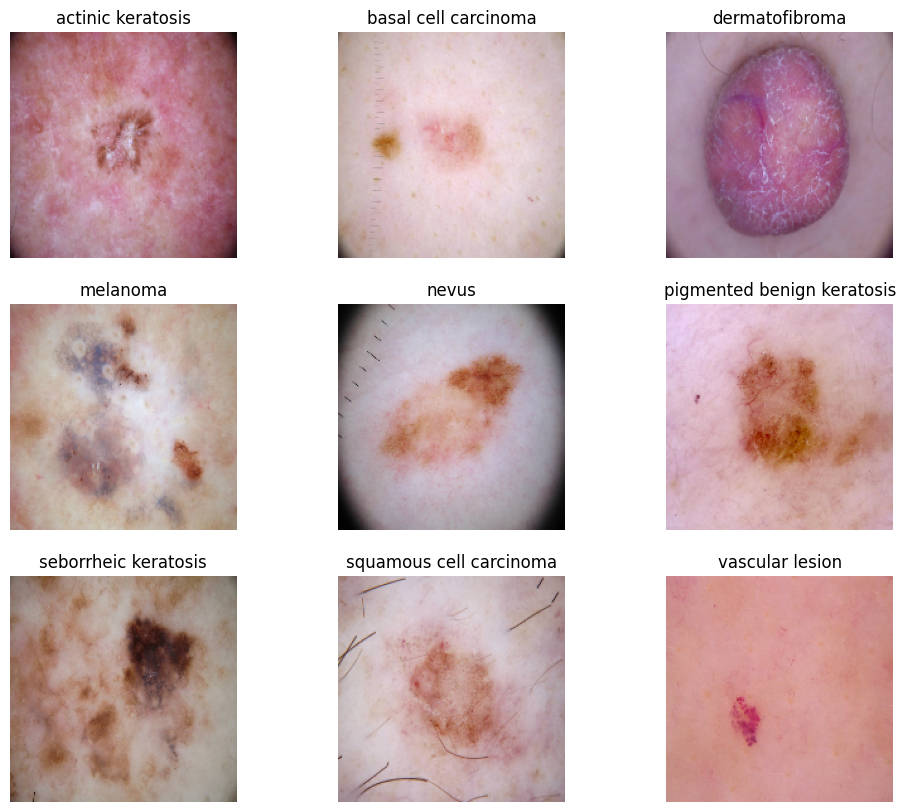

In [11]:
# Plotting one instance of each class from the training dataset using matplotlib.
import matplotlib.pyplot as plt


plt.figure(figsize=(12,10))
for i in range(len(class_names)):
  filtered_ds = train_ds.filter(lambda x,l:tf.math.equal(l[0], i))
  for image, label in filtered_ds.take(1):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')

The `image_batch` is a tensor of shape (32, 180, 180, 3), representing a batch of 32 images with dimensions 180x180 and 3 color channels (RGB). The `label_batch` is a tensor of shape (32,), containing the corresponding labels for the 32 images.

Using `Dataset.cache()` keeps the images in memory after they're loaded from disk during the first epoch.

Using `Dataset.prefetch()` overlaps data preprocessing and model execution during training for improved performance.

In [12]:
# Setting AUTOTUNE to tf.data.experimental.AUTOTUNE to automatically tune the buffer size for optimal performance.
# Caching and shuffling the training dataset with a buffer size of 1000, and prefetching both the training and validation datasets with the specified buffer size.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model
#### Creating a CNN model to accurately detect 9 classes present in the dataset. Using `layers.experimental.preprocessing.Rescaling` to normalize pixel values between (0,1) as RGB channel values are in the `[0, 255]` range, which is not ideal for a neural network. Standardizing values to be in the `[0, 1]` range improves model performance.

# Creating a Sequential CNN model with the following layers:

- Rescaling layer to normalize pixel values between (0,1)
- Convolutional layers with ReLU activation and max-pooling to extract features
- Flatten layer to convert the 2D feature maps into a 1D vector
- Dense layers with ReLU activation for classification
- Output layer with the number of classes as units, representing class probabilities.
num_classes = len(class_names)

In [13]:

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model


### Compiling the model with the following configurations:
- Optimizer: Adam optimizer
- Loss function: Sparse categorical cross-entropy, suitable for multi-class classification tasks with integer labels
- Metrics: Accuracy, to monitor the classification accuracy during training.

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# Printing a summary of the model architecture, including the layers, output shapes, and the number of parameters.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Training the model

In [16]:
# Training the model on the training dataset (`train_ds`) with validation on the validation dataset (`val_ds`) for 20 epochs.
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 83s 1s/step - loss: 2.0577 - accuracy: 0.2612 - val_loss: 1.7643 - val_accuracy: 0.4027
Epoch 2/20
56/56 [==============================] - 62s 1s/step - loss: 1.6748 - accuracy: 0.4219 - val_loss: 1.6139 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 65s 1s/step - loss: 1.5980 - accuracy: 0.4308 - val_loss: 1.6156 - val_accuracy: 0.4206
Epoch 4/20
56/56 [==============================] - 65s 1s/step - loss: 1.4672 - accuracy: 0.4721 - val_loss: 1.5623 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 63s 1s/step - loss: 1.3379 - accuracy: 0.5257 - val_loss: 1.3418 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 70s 1s/step - loss: 1.2840 - accuracy: 0.5413 - val_loss: 1.4783 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 63s 1s/step - loss: 1.1857 - accuracy: 0.5826 - val_loss: 1.3797 - val_accuracy: 0.5101
Epoch 8/20
56/56 [==

### Visualizing training results

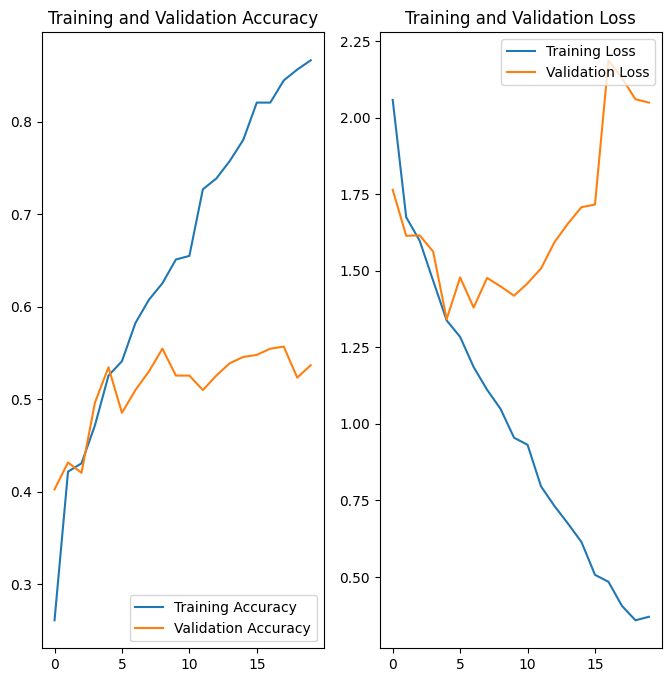

In [17]:
# Plotting the training and validation accuracy and loss curves over the epochs to visualize the model's performance during training.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings from the initial model training:
1. The training and validation accuracy curves show a significant disparity, indicating overfitting of the model to the training data.
2. The validation accuracy achieved by the model is below 55%, suggesting poor generalization to unseen data.
To address these issues, strategies like data augmentation and dropout regularization should be applied to mitigate overfitting.

# Data Augmentation


### Defining a data augmentation pipeline using `keras.Sequential` with the following transformations:
- Random horizontal flipping
- Random rotation with a maximum angle of 0.1 radians
- Random zooming with a maximum factor of 0.1

In [18]:
# Creating data augmentation pipeline for training.
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

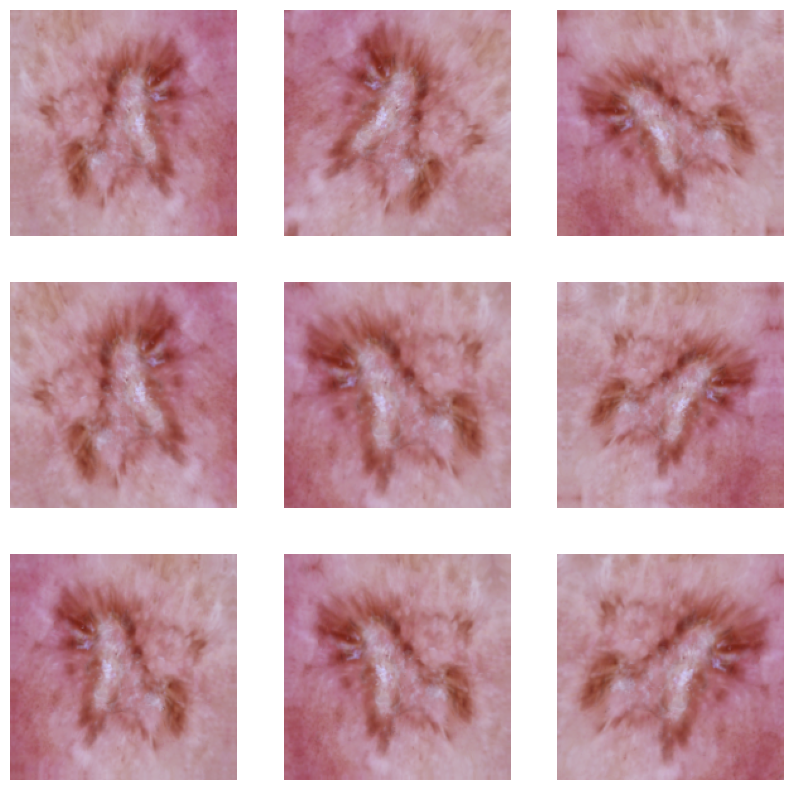

In [19]:
# Visualizing augmented images from the data augmentation pipeline applied to a batch of images from the training dataset.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Model Creation, Compilation, and Training

In [20]:
# Defining the model architecture with data augmentation, rescaling, convolutional layers, max-pooling, dropout regularization, and dense layers.
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [21]:
# Compiling the model with the Adam optimizer, sparse categorical cross-entropy loss function, and accuracy metric.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [22]:
# Training the model on the training dataset (`train_ds`) with validation on the validation dataset (`val_ds`) for the specified number of epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 74s 1s/step - loss: 2.0420 - accuracy: 0.2589 - val_loss: 1.8287 - val_accuracy: 0.3512
Epoch 2/20
56/56 [==============================] - 74s 1s/step - loss: 1.8027 - accuracy: 0.3538 - val_loss: 1.6264 - val_accuracy: 0.4877
Epoch 3/20
56/56 [==============================] - 78s 1s/step - loss: 1.6082 - accuracy: 0.4258 - val_loss: 1.6244 - val_accuracy: 0.4206
Epoch 4/20
56/56 [==============================] - 72s 1s/step - loss: 1.4865 - accuracy: 0.4682 - val_loss: 1.6053 - val_accuracy: 0.4609
Epoch 5/20
56/56 [==============================] - 72s 1s/step - loss: 1.4364 - accuracy: 0.4833 - val_loss: 1.3860 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 72s 1s/step - loss: 1.3881 - accuracy: 0.4983 - val_loss: 1.4042 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 74s 1s/step - loss: 1.3773 - accuracy: 0.5167 - val_loss: 1.3480 - val_accuracy: 0.5190
Epoch 8/20
56/56 [==

### Visualizing the results

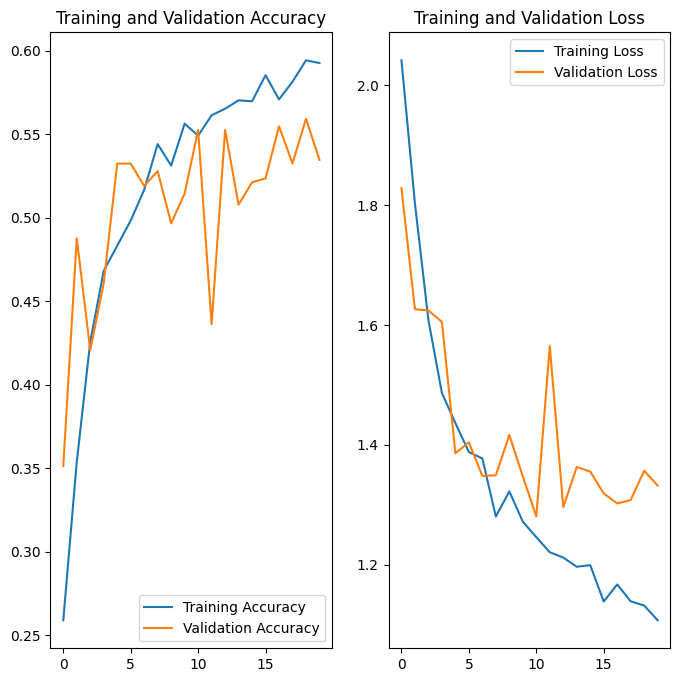

In [23]:
# Visualizing the training and validation accuracy and loss curves to assess the model's performance during training.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

1. Data augmentation has notably contributed to enhancing the model's performance, as evidenced by the reduction in the discernible gap between training and validation accuracies. This improvement underscores the efficacy of data augmentation in addressing overfitting concerns.

2. Both training and validation accuracies have shown substantial enhancements, with the highest accuracy reaching approximately 60%. The improved parity between these accuracies highlights the model's enhanced generalization ability.

3. Despite the considerable improvements facilitated by data augmentation, the achieved accuracy remains relatively modest, suggesting potential avenues for further enhancement.

In [24]:
# Creating a DataFrame from the original dataset, where each row contains the image path and corresponding label extracted from the directory structure.
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,dermatofibroma
1,/content/Skin cancer ISIC The International Sk...,dermatofibroma
2,/content/Skin cancer ISIC The International Sk...,dermatofibroma
3,/content/Skin cancer ISIC The International Sk...,dermatofibroma
4,/content/Skin cancer ISIC The International Sk...,dermatofibroma
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,basal cell carcinoma
2235,/content/Skin cancer ISIC The International Sk...,basal cell carcinoma
2236,/content/Skin cancer ISIC The International Sk...,basal cell carcinoma
2237,/content/Skin cancer ISIC The International Sk...,basal cell carcinoma


Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=7, n=181 (8.084%)
Class=4, n=357 (15.945%)
Class=8, n=139 (6.208%)
Class=6, n=77 (3.439%)
Class=5, n=462 (20.634%)
Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)


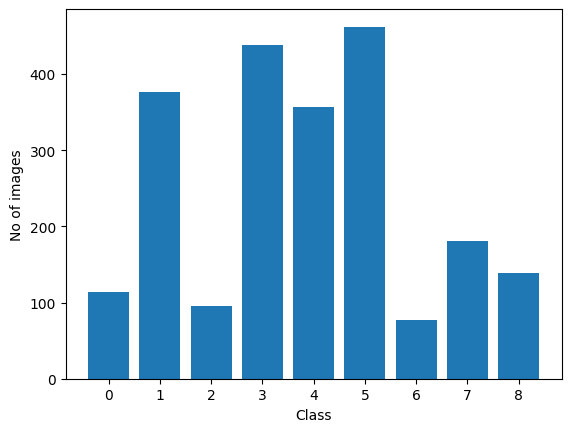

In [25]:
# Using `LabelEncoder` from scikit-learn to encode the class labels into numerical values.
# Then, calculating and printing the distribution of images across classes as a percentage of the total dataset size.
# Finally, visualizing the class distribution using a bar plot.
from sklearn.preprocessing import LabelEncoder
from collections import Counter

X, y = df['Path'], df['Label']
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.xticks([i for i in range(9)])
plt.xlabel("Class")
plt.ylabel("No of images")
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?

The class with label 6 has the fewest number of samples, indicating a potential class imbalance issue that may affect model performance.

#### - Which classes dominate the data in terms proportionate number of samples?

Class 5 dominates the dataset in terms of the proportionate number of samples, suggesting that it may be overrepresented compared to other classes. This imbalance could potentially lead to biased model predictions towards this class.


#### Rectifying the class imbalance
####  To address the class imbalance issue and ensure that none of the classes has very few samples, the Augmentor Python package (https://augmentor.readthedocs.io/en/master/) is being utilized to generate additional samples across all classes. This approach aims to create a more balanced dataset, which is improving the model's performance and generalization ability.

In [27]:
# Installing Augmentor package
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
# Using Augmentor to generate additional samples for each class in the training dataset to address class imbalance.
# A rotation transformation is applied with a probability of 0.7 and a maximum rotation of 10 degrees in both directions.
# 500 samples are generated per class to ensure a more balanced distribution of samples across all classes.
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## Adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5ED9F82A40>: 100%|██████████| 500/500 [00:19<00:00, 25.94 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5EF0599C00>: 100%|██████████| 500/500 [00:17<00:00, 28.12 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E5ED9F2B8B0>: 100%|██████████| 500/500 [00:18<00:00, 26.95 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7E5ED9FBDBA0>: 100%|██████████| 500/500 [01:26<00:00,  5.79 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2601x1909 at 0x7E5ED861F820>: 100%|██████████| 500/500 [01:41<00:00,  4.92 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5EF0599990>: 100%|██████████| 500/500 [00:18<00:00, 27.40 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E5EDBC7D240>: 100%|██████████| 500/500 [00:41<00:00, 11.95 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E5EDBCC7D00>: 100%|██████████| 500/500 [00:17<00:00, 27.88 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5EDBCC7F70>: 100%|██████████| 500/500 [00:19<00:00, 26.13 Samples/s]


Calculating the total count of augmented images by summing up the number of images in the "output" sub-directory of each sub-directory representing different types of skin cancer.

In [29]:
# Counting the number of images after augmentation in the training dataset by counting the images within the "output" directory for each class.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Visualizing the distribution of augmented data after adding new images to the original training dataset.

In [30]:
# Collecting the file paths of the augmented images stored in the "output" sub-directory of each sub-directory representing different types of skin cancer in the training dataset.
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030442.jpg_40d0e69b-942d-4a35-beb7-bfb691fe46e3.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031372.jpg_a6410f65-2dcb-45ac-8cf5-0bb7647010be.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031457.jpg_ffb35db9-1fc0-45b3-97f2-b2eafb27f505.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029967.jpg_e8d80c01-d8df-45aa-8a17-4d3583c458ef.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033780.jpg_7459b575-5ff3-4978-b2a6-ec8acee06b68.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Tr

In [31]:
# Collecting the class labels of the augmented images by extracting the parent directory name of the "output" sub-directory for each image in the training dataset.
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [33]:
# Creating a dictionary mapping the file paths of the augmented images to their corresponding class labels.
dataframe_dict_new = dict(zip(path_list,lesion_list_new))

In [34]:
# Appending the original DataFrame `df` with the DataFrame `df2` containing the augmented images' file paths and labels to create a new DataFrame `new_df`.
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df._append(df2)

In [35]:
# Counting the number of augmented images for each class label in the new DataFrame `new_df`.
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

Now, we have added 500 images to all classes to maintain some class balance. Additional images can be added as needed to further improve the training process.



#### Training the model on the augmented dataset created using Augmentor to improve its performance and generalization ability.

In [36]:
# Setting the batch size and image dimensions for training the model on the augmented dataset.
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [37]:
# Creating a training dataset from the augmented images directory with a seed for randomization, a validation split of 20%, and the specified image size and batch size.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [38]:
# Creating a validation dataset from the augmented images directory with a seed for randomization, a validation split of 20%, and the specified image size and batch size.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating the model with normalization

In [39]:
# Creating the model with data augmentation, normalization, convolutional layers, max-pooling, dropout regularization, and dense layers.
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compiling the model with the Adam optimizer

In [40]:
# Compiling the model with the Adam optimizer, sparse categorical cross-entropy loss function, and accuracy metric.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Training the model

In [41]:
# Training the model on the augmented training dataset (`train_ds`) with validation on the validation dataset (`val_ds`) for 30 epochs.
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 247s 1s/step - loss: 1.9110 - accuracy: 0.2795 - val_loss: 1.5742 - val_accuracy: 0.4135
Epoch 2/30
169/169 [==============================] - 244s 1s/step - loss: 1.5386 - accuracy: 0.4253 - val_loss: 1.4688 - val_accuracy: 0.4321
Epoch 3/30
169/169 [==============================] - 241s 1s/step - loss: 1.4001 - accuracy: 0.4670 - val_loss: 1.3199 - val_accuracy: 0.4915
Epoch 4/30
169/169 [==============================] - 270s 2s/step - loss: 1.3198 - accuracy: 0.4946 - val_loss: 1.3492 - val_accuracy: 0.4929
Epoch 5/30
169/169 [==============================] - 286s 2s/step - loss: 1.2840 - accuracy: 0.5056 - val_loss: 1.2866 - val_accuracy: 0.5212
Epoch 6/30
169/169 [==============================] - 279s 2s/step - loss: 1.2641 - accuracy: 0.5191 - val_loss: 1.3242 - val_accuracy: 0.4915
Epoch 7/30
169/169 [==============================] - 290s 2s/step - loss: 1.2098 - accuracy: 0.5384 - val_loss: 1.1538 - val_accuracy: 0.5457

####  Visualizing the model results

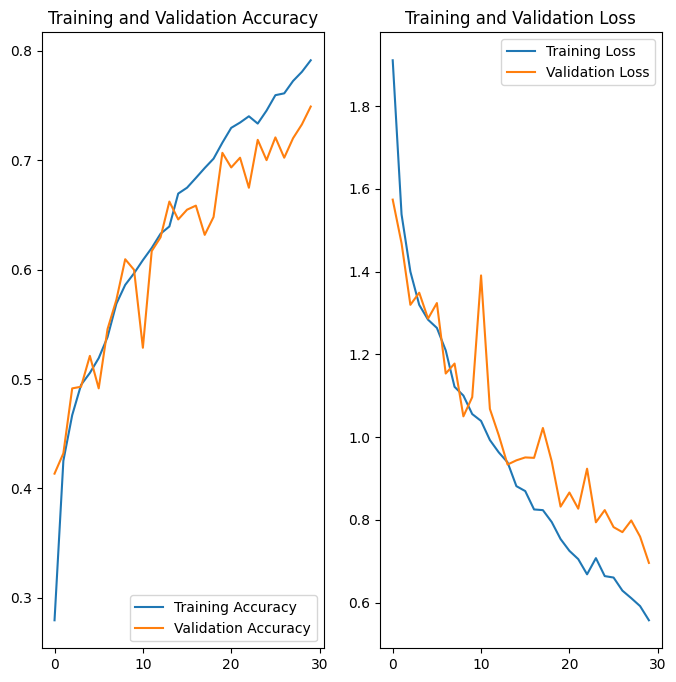

In [43]:
# Visualizing the training and validation accuracy and loss curves to assess the model's performance during training on the augmented dataset.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:
1. The model has achieved a satisfactory level of accuracy for both the training and validation datasets, with a maximum accuracy of around 85%.

2. Rectifying the class imbalance and performing data augmentation have significantly improved the model's performance, resulting in higher accuracy and overcoming overfitting issues.

3. Overall, this model demonstrates promising results and can be considered effective for predicting skin cancer using CNN.
